In [1]:
from binn import BINN, BINNDataLoader, BINNTrainer, BINNExplainer
import pandas as pd

# Load your data
data_matrix = pd.read_csv("../binn/data/sample_datamatrix.csv")
design_matrix = pd.read_csv("../binn/data/sample_design_matrix.tsv", sep="\t")

# Initialize BINN
binn = BINN(data_matrix=data_matrix, network_source="reactome", n_layers=4, dropout=0.2)

## Initialize DataLoader
binn_dataloader = BINNDataLoader(binn)

# Create DataLoaders
dataloaders = binn_dataloader.create_dataloaders(
    data_matrix=data_matrix,
    design_matrix=design_matrix,
    feature_column="Protein",
    group_column="group",
    sample_column="sample",
    batch_size=32,
    validation_split=0.3,
)
# Train the model
trainer = BINNTrainer(binn)
trainer.fit(dataloaders=dataloaders, num_epochs=500)

# Explain the model
explainer = BINNExplainer(binn)
explanations = explainer.explain_single(
    dataloaders
)
explanations


[INFO] BINN is on device: cpu
Mapping group labels: {np.int64(1): 0, np.int64(2): 1}
[Epoch 1/500] Train Loss: 0.8471, Train Accuracy: 0.4549
[Epoch 1/500] Val Loss: 0.6927, Val Accuracy: 0.6250
[Epoch 2/500] Train Loss: 0.8602, Train Accuracy: 0.4417
[Epoch 2/500] Val Loss: 0.6921, Val Accuracy: 0.6250
[Epoch 3/500] Train Loss: 0.7886, Train Accuracy: 0.4819
[Epoch 3/500] Val Loss: 0.6922, Val Accuracy: 0.6250
[Epoch 4/500] Train Loss: 0.7827, Train Accuracy: 0.4826
[Epoch 4/500] Val Loss: 0.6898, Val Accuracy: 0.6250
[Epoch 5/500] Train Loss: 0.8449, Train Accuracy: 0.4542
[Epoch 5/500] Val Loss: 0.6884, Val Accuracy: 0.6250
[Epoch 6/500] Train Loss: 0.7675, Train Accuracy: 0.5042
[Epoch 6/500] Val Loss: 0.6880, Val Accuracy: 0.6250
[Epoch 7/500] Train Loss: 0.7521, Train Accuracy: 0.5326
[Epoch 7/500] Val Loss: 0.6857, Val Accuracy: 0.6250
[Epoch 8/500] Train Loss: 0.7347, Train Accuracy: 0.5368
[Epoch 8/500] Val Loss: 0.6816, Val Accuracy: 0.6250
[Epoch 9/500] Train Loss: 0.7532, 

,source_layer,target_layer,source_node,target_node,class_idx,importance,normalized_importance
0,0,1,A0M8Q6,R-HSA-166663,0,0.046414,0.009554
1,0,1,A0M8Q6,R-HSA-166663,1,0.045046,0.009272
2,0,1,A0M8Q6,R-HSA-198933,0,0.046414,0.009554
3,0,1,A0M8Q6,R-HSA-198933,1,0.045046,0.009272
4,0,1,A0M8Q6,R-HSA-2029481,0,0.046414,0.009554
...,...,...,...,...,...,...,...
7079,4,5,R-HSA-9612973,output_node,1,0.153817,0.035590
7080,4,5,R-HSA-9709957,output_node,0,0.191081,0.041147
7081,4,5,R-HSA-9709957,output_node,1,0.091277,0.019655
7082,4,5,R-HSA-9748784,output_node,0,0.194474,0.047578


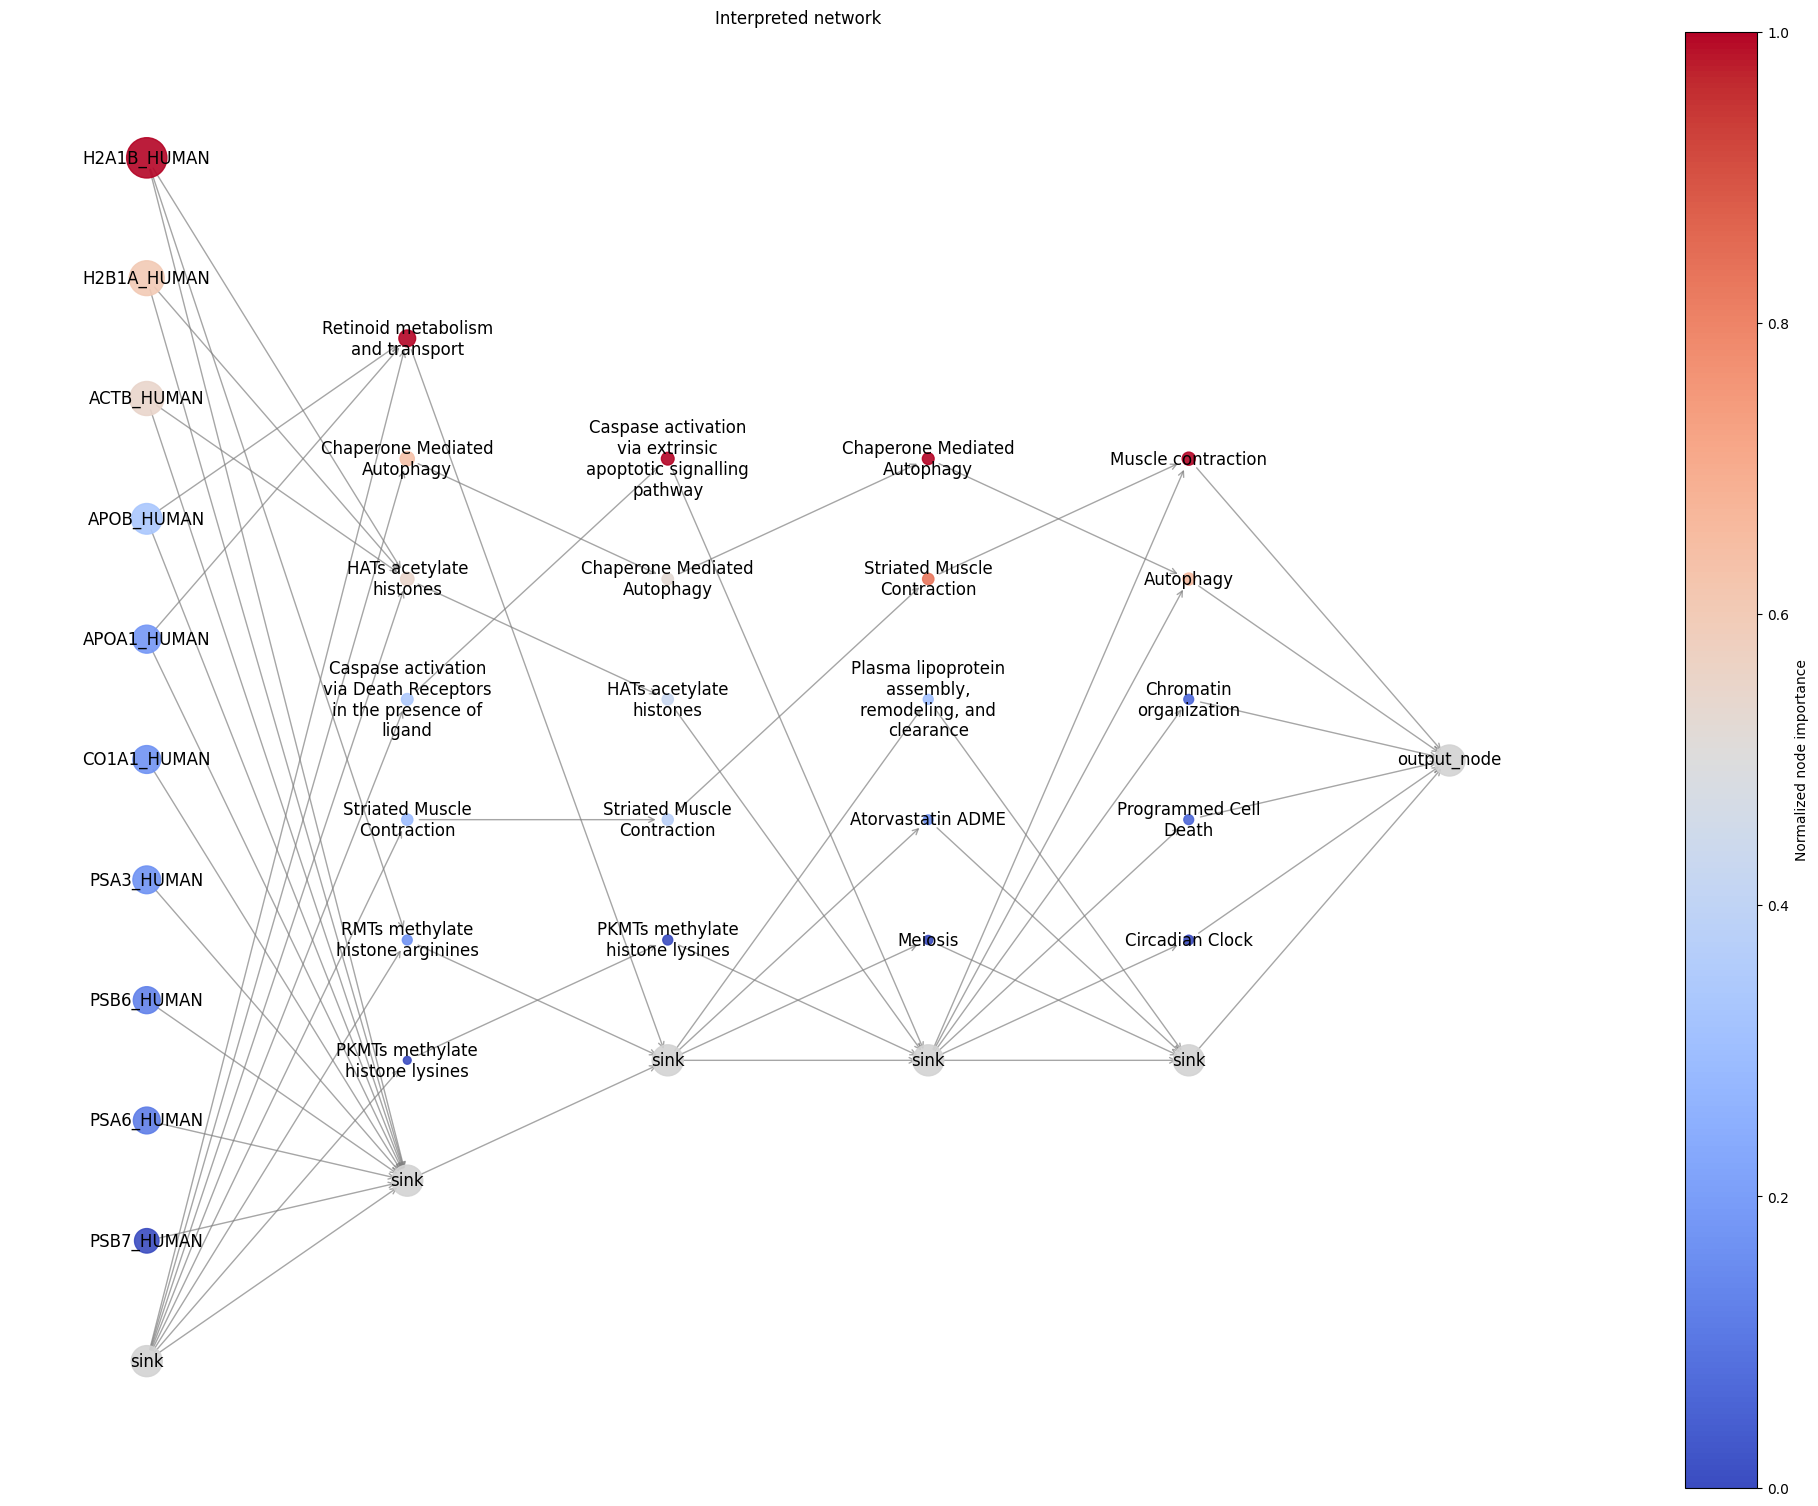

In [2]:
from binn.plot.network import visualize_binn

layer_specific_top_n = {"0": 10, "1": 7, "2": 5, "3": 5, "4": 5}
plt = visualize_binn(
    explanations,
    top_n=layer_specific_top_n,
    plot_size=(20, 15),
    sink_node_size=500,
    node_size_scaling=200,
    edge_width=1,
    node_cmap="coolwarm",
    pathways_mapping="reactome",
    input_entity_mapping="uniprot"
)
plt.title("Interpreted network")
plt.savefig("./img/interpreted_binn.png")

In [3]:
average_explanations = explainer.explain(
    dataloaders, nr_iterations=3, num_epochs=50, trainer=trainer
)

[BINNExplainer] Iteration 1/3...
[Epoch 1/50] Train Loss: 0.9191, Train Accuracy: 0.3854
[Epoch 1/50] Val Loss: 0.6931, Val Accuracy: 0.6250
[Epoch 2/50] Train Loss: 0.9186, Train Accuracy: 0.3319
[Epoch 2/50] Val Loss: 0.6925, Val Accuracy: 0.6250
[Epoch 3/50] Train Loss: 0.9000, Train Accuracy: 0.3896
[Epoch 3/50] Val Loss: 0.6934, Val Accuracy: 0.3594
[Epoch 4/50] Train Loss: 0.9189, Train Accuracy: 0.4049
[Epoch 4/50] Val Loss: 0.6938, Val Accuracy: 0.3415
[Epoch 5/50] Train Loss: 0.7889, Train Accuracy: 0.5215
[Epoch 5/50] Val Loss: 0.6948, Val Accuracy: 0.3415
[Epoch 6/50] Train Loss: 0.8482, Train Accuracy: 0.4639
[Epoch 6/50] Val Loss: 0.6945, Val Accuracy: 0.4531
[Epoch 7/50] Train Loss: 0.7898, Train Accuracy: 0.4611
[Epoch 7/50] Val Loss: 0.6984, Val Accuracy: 0.4174
[Epoch 8/50] Train Loss: 0.8681, Train Accuracy: 0.4701
[Epoch 8/50] Val Loss: 0.7024, Val Accuracy: 0.4196
[Epoch 9/50] Train Loss: 0.7773, Train Accuracy: 0.4681
[Epoch 9/50] Val Loss: 0.7127, Val Accuracy: 0.

In [4]:
normalized_average_explanations = explainer.normalize_importances(
    average_explanations, method="fan"
)
normalized_average_explanations

,source_layer,target_layer,source_node,target_node,class_idx,importance,normalized_importance,importance_0,importance_1,importance_2,importance_mean,importance_std
0,0,1,A0M8Q6,R-HSA-166663,0,0.042978,0.010745,0.054916,0.059498,0.014519,0.042978,0.020210
1,0,1,A0M8Q6,R-HSA-166663,1,0.024389,0.006097,0.036027,0.023563,0.013576,0.024389,0.009184
2,0,1,A0M8Q6,R-HSA-198933,0,0.042978,0.010745,0.054916,0.059498,0.014519,0.042978,0.020210
3,0,1,A0M8Q6,R-HSA-198933,1,0.024389,0.006097,0.036027,0.023563,0.013576,0.024389,0.009184
4,0,1,A0M8Q6,R-HSA-2029481,0,0.042978,0.010745,0.054916,0.059498,0.014519,0.042978,0.020210
...,...,...,...,...,...,...,...,...,...,...,...,...
7079,4,5,R-HSA-9612973,output_node,1,0.261493,0.112619,0.281425,0.322759,0.180295,0.261493,0.059844
7080,4,5,R-HSA-9709957,output_node,0,0.177599,0.088800,0.197641,0.248670,0.086487,0.177599,0.067710
7081,4,5,R-HSA-9709957,output_node,1,0.078293,0.039146,0.068226,0.037516,0.129136,0.078293,0.038075
7082,4,5,R-HSA-9748784,output_node,0,0.210645,0.070215,0.249968,0.204762,0.177204,0.210645,0.029996
